In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel

In [2]:
def read_wine_data() -> pd.DataFrame:
    df_wine = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
        header=None
    )

    df_wine.columns = [
        'Class label', 'Alcohol', 'Malic acid', 'Ash',
        'Alcalinity of ash', 'Magnesium', 'Total phenols',
        'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
        'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
        'Proline'
    ]

    print('Class labels', np.unique(df_wine['Class label']))
    return df_wine

In [3]:
WINE_DF = read_wine_data()

Class labels [1 2 3]


In [4]:
WINE_DF.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
def split_data_by_ratio(df_wine: pd.DataFrame, ratio=0.3) -> tuple:
    X = df_wine.iloc[:, 1:].values 
    y = df_wine.iloc[:, 0].values
    # explanation:
    # test size: Divide the data into 30% test and 70% train
    # random_state: A random seed for exact same split of data every time
    # startify: make sure that train and test sample has data from all classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,test_size=ratio, random_state=13, stratify=y  # ratio devides in 30,70 and stratify makes groups of the data according to the given column
    )
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, Y_train, Y_test = split_data_by_ratio(WINE_DF) #providing the frame to the slit data function

In [7]:
#scaling the data, all values between 0 and 1
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train) # the data is being calculated for the data frame

X_train_norm = min_max_scaler.transform(X_train) # now the data frame is being transformed between 0 and 1
X_test_norm = min_max_scaler.transform(X_test)

In [9]:
lr_model = LogisticRegression(solver='liblinear', multi_class='ovr')
lr_model.fit(X_train_norm, Y_train)

print('Training accuracy:', lr_model.score(X_train_norm, Y_train))
print('Test accuracy:', lr_model.score(X_test_norm, Y_test))

Training accuracy: 0.9919354838709677
Test accuracy: 0.9814814814814815


In [29]:
def accuracy_manual(lr_model: LogisticRegression, X_train_norm: list, Y_train: list):
    validation_df = pd.DataFrame(zip(lr_model.predict(X_train_norm), Y_train), columns=["predicted", "actual"]) # predicting the data using the  logistic regression by passing the normalized dsta frame
    validation_df["is_equal"] = validation_df["predicted"] == validation_df["actual"] # testing if predicted 0 and 1 values are equal or not
    acc = validation_df["is_equal"].sum()/len(validation_df) # calculating the percentage of data
    print("The accuracy is {}".format(acc))

In [30]:
accuracy_manual(lr_model, X_train_norm, Y_train) # using the accuracy function and providing the prevously calculated values

The accuracy is 0.9919354838709677


In [33]:
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, Y_train) # providing the same data to random forest 

RandomForestClassifier(n_estimators=500, random_state=1)

 1) Color intensity                0.180033
 2) Proline                        0.160545
 3) Flavanoids                     0.141453
 4) Alcohol                        0.128205
 5) OD280/OD315 of diluted wines   0.118041
 6) Total phenols                  0.062422
 7) Hue                            0.060727
 8) Alcalinity of ash              0.041400
 9) Magnesium                      0.031926
10) Proanthocyanins                0.025657
11) Malic acid                     0.021687
12) Nonflavanoid phenols           0.014125
13) Ash                            0.013777


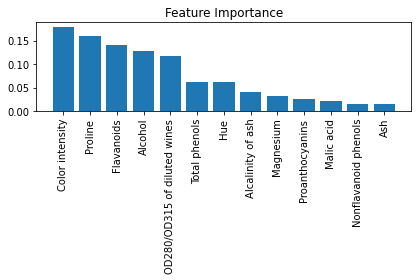

In [54]:
feat_labels = WINE_DF.columns[1:] # labeling using the class column from data frame
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1] # sorting according to their imporance

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,  # applying formula
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), # creating the plot
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90) # providing the lables along x axis
plt.xlim([-1, X_train.shape[1]]) #providing xlim
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

In [56]:
sfm = SelectFromModel(forest, threshold=0.1, prefit=True) #selecting features based on importance weights

X_selected = sfm.transform(X_train) # ransforming the selected data from the forest modle
print('Number of features that meet this threshold criterion:', X_selected.shape[1])

Number of features that meet this threshold criterion: 5


In [57]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Color intensity                0.180033
 2) Proline                        0.160545
 3) Flavanoids                     0.141453
 4) Alcohol                        0.128205
 5) OD280/OD315 of diluted wines   0.118041


In [60]:
# taking the 6 important features which has greater impact according to the finding
SUBSET_DF = WINE_DF[["Class label","Color intensity", "Proline", "Flavanoids", "Alcohol", "OD280/OD315 of diluted wines",]].copy()

In [61]:
SUBSET_DF.head()

,Class label,Color intensity,Proline,Flavanoids,Alcohol,OD280/OD315 of diluted wines
0,1,5.64,1065,3.06,14.23,3.92
1,1,4.38,1050,2.76,13.20,3.40
2,1,5.68,1185,3.24,13.16,3.17
3,1,7.80,1480,3.49,14.37,3.45
4,1,4.32,735,2.69,13.24,2.93


In [62]:
X_train, X_test, Y_train, Y_test = split_data_by_ratio(SUBSET_DF) # providing the data frame to the split data function

In [63]:
# scailing the data between 0 and 1
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)

X_train_norm = min_max_scaler.transform(X_train)
X_test_norm = min_max_scaler.transform(X_test)

In [65]:
# applying the logistic regression again using only the 6 important columns
lr_model = LogisticRegression(solver='liblinear', multi_class='ovr') 
lr_model.fit(X_train_norm, Y_train)

print('Training accuracy:', lr_model.score(X_train_norm, Y_train))
print('Test accuracy:', lr_model.score(X_test_norm, Y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9814814814814815
